Aya Eid

Tempus Test Case

# Include imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline

# Reading in and structuring data

In [26]:
targets = pd.read_csv('targets.csv')
features = pd.read_csv('biomarkers.csv')

In [27]:
# taking a look 
targets.head()

,patient_id,biomarker_id,target_label
0,1002df1d3,89c43bb4,0
1,1010441f,3ae31327,0
2,101eb6af1,1d8f7bab9,0
3,10204394e,129ee8c6c,0
4,1021d329b,1b44145bd,0


In [28]:
# Here we set up the data set
# if there's no target, there's no need for that observation, so we start first with the biomarker id
data = pd.DataFrame(columns=['biomarker_id','patient_id','target','institution','gender','age','race','dst','comind','coq','smoking','msd'])
data['biomarker_id'] = targets['biomarker_id']
data['patient_id'] = targets['patient_id']
data['target'] = targets['target_label']

In [5]:
# Next we connect the biomarker id to the patient id to get additional data points
with open("patient_profiles.json", "r") as read_file:
    patient_profiles = json.load(read_file)


In [34]:
# while this isn't the fastest, it could be optimized or parallelized for larger datasets
def check(val):
    if val:
        return val
    else:
        return np.nan
    
def gToBinary(gStr):
    gStr = check(gStr)
    if gStr.lower() == 'male':
        return 0
    elif gStr.lower() == 'female':
        return 1
    

for inst_ind in range(0,len(patient_profiles)):
    print('Read in: ', inst_ind/(len(patient_profiles)-1))
          
    for pat_ind in range(0, len(patient_profiles[inst_ind]["patient_profiles"])):   
        pid = patient_profiles[inst_ind]["patient_profiles"][pat_ind]['patient_id']
        ploc = data['patient_id']==pid
               
        data['institution'].loc[ploc] = check(patient_profiles[inst_ind]["institution"])
        data['gender'].loc[ploc] = check(patient_profiles[inst_ind]["patient_profiles"][pat_ind]['demographics'].get('gender'))
        data['age'].loc[ploc] = check(patient_profiles[inst_ind]["patient_profiles"][pat_ind]['demographics'].get('age'))        
        data['race'].loc[data['biomarker_id']==pid] = check(patient_profiles[inst_ind]["patient_profiles"][pat_ind]['demographics'].get('race'))
        
        data['dst'].loc[data['biomarker_id']==pid] = check(patient_profiles[inst_ind]["patient_profiles"][pat_ind]['status'].get('disease_sub_type'))
        data['comind'].loc[data['biomarker_id']==pid] = check(patient_profiles[inst_ind]["patient_profiles"][pat_ind]['status'].get('comorbidity_index'))
        data['coq'].loc[data['biomarker_id']==pid] = check(patient_profiles[inst_ind]["patient_profiles"][pat_ind]['status'].get('cohort_qualifier'))
        data['smoking'].loc[data['biomarker_id']==pid] = check(patient_profiles[inst_ind]["patient_profiles"][pat_ind]['status'].get('smoking_status'))
        data['msd'].loc[data['biomarker_id']==pid] = check(patient_profiles[inst_ind]["patient_profiles"][pat_ind]['status'].get('months_since_diagnosis'))
        
data['gender'] = data['gender'].apply(gToBinary)                

Read in:  0.0
Read in:  0.16666666666666666
Read in:  0.3333333333333333
Read in:  0.5
Read in:  0.6666666666666666
Read in:  0.8333333333333334
Read in:  1.0


In [35]:
def nanToVal(v):
    if(np.isnan(v)):
        return 0
    else:
        return v
    
    
#data["age"] = data["age"].apply(nanToVal)    

data = data.iloc[:,0:6]
data.dropna(axis=0,inplace=True)
#data.head()

  biomarker_id patient_id  target                 institution  gender age
0     89c43bb4  1002df1d3       0  University Hospital System       0  46
1     3ae31327   1010441f       0           Montague Hospital       0  52
2    1d8f7bab9  101eb6af1       0                BioLab, Inc.       1  55
3    129ee8c6c  10204394e       0  University Hospital System       0  69
4    1b44145bd  1021d329b       0  University Hospital System       0  52


C:\Users\ayaei\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\ayaei\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


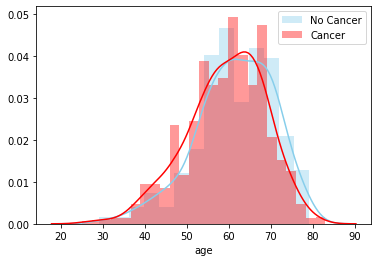

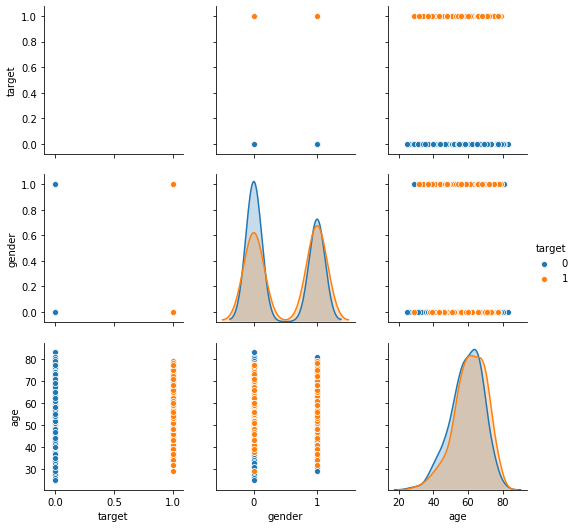

In [37]:
# Finally, for each biomarker_id, we need to load in the atual features
print(data.head())
#sns.distplot()
#plt.hist([data['']])



sns.distplot( data[data['target']==1]['age'] , color="skyblue", label="No Cancer")
sns.distplot( data[data['target']==0]['age'], color="red", label="Cancer")
plt.legend()

sns.pairplot(data,hue='target')

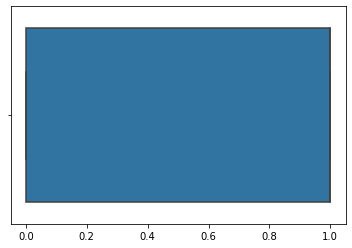

In [61]:
f = features.iloc[:,-3:]
#sns.pairplot(features.iloc[:,-3:],hue=features['target'])
#features.iloc[:,2:10].head(10)
#features['target'].shape
#features.iloc[:,1:10].shape
sns.boxplot(f)#,hue='target')

In [29]:
# append targets to features to establish data matrix

features['target'] = np.full(len(features),np.nan)
for b_ind in range(0, len(data)):   
    bid = data.loc[b_ind]['biomarker_id']
    target = data.loc[b_ind]['target']
    features.target.loc[features['biomarker_id']==bid] = target

# remove any observations without target data
features.dropna(subset=['target'],inplace=True)    

C:\Users\ayaei\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [33]:
# Looking a little closer at the data, I found a few features that have numerous missing values. For now, let's just remove them entirely
features.dropna(axis=1,inplace=True)


In [9]:
from sklearn.model_selection import train_test_split
#X = features.drop(['target','biomarker_id'],axis=1)
#y = features['target']


cat_feats = ['institution']
data = pd.get_dummies(data.drop(['biomarker_id','patient_id'],axis=1),columns=cat_feats,drop_first=True)
data['age'] = data['age'].apply(int)
X = data.drop(['target'],axis=1)
y = data['target']

#X = X.to_numpy()
#y = y.to_numpy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
X.info()

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1611 entries, 0 to 1733
Data columns (total 6 columns):
gender                                       1611 non-null int64
age                                          1611 non-null int64
institution_Johnson & Bloom Hospitals        1611 non-null uint8
institution_Montague Hospital                1611 non-null uint8
institution_Saint Penelope Medical Center    1611 non-null uint8
institution_University Hospital System       1611 non-null uint8
dtypes: int64(2), uint8(4)
memory usage: 44.1 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1611 entries, 0 to 1733
Data columns (total 7 columns):
target                                       1611 non-null int64
gender                                       1611 non-null int64
age                                          1611 non-null int64
institution_Johnson & Bloom Hospitals        1611 non-null uint8
institution_Montague Hospital                1611 non-null uint8
institution_Saint Penelo

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88       532
           1       0.00      0.00      0.00         0

    accuracy                           0.79       532
   macro avg       0.50      0.39      0.44       532
weighted avg       1.00      0.79      0.88       532

[[419 113]
 [  0   0]]


C:\Users\ayaei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ayaei\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Neural Network

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1)) 
model.compile(optimizer='rmsprop',loss='mse')  # optimzer depends on type of problem (binary, multiclass or regression)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
model.fit(x=X_train,y=y_train, epochs=250,verbose=0)

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [ ]:
predictions = np.round(model.predict(X_test))

In [ ]:
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))


In [14]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=0)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [16]:
predictions = dtree.predict(X_test)
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       478
           1       0.11      0.22      0.14        54

    accuracy                           0.73       532
   macro avg       0.50      0.51      0.49       532
weighted avg       0.82      0.73      0.77       532

[[377 101]
 [ 42  12]]


In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [18]:
clf.feature_importances_
predictions = clf.predict(X_test)

print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88       524
           1       0.03      0.38      0.05         8

    accuracy                           0.78       532
   macro avg       0.51      0.58      0.46       532
weighted avg       0.97      0.78      0.87       532

[[414 110]
 [  5   3]]


In [19]:
from sklearn.ensemble import RandomForestClassifier

[[375 101]
 [ 44  12]]


              precision    recall  f1-score   support

           0       0.89      0.79      0.84       476
           1       0.11      0.21      0.14        56

    accuracy                           0.73       532
   macro avg       0.50      0.50      0.49       532
weighted avg       0.81      0.73      0.76       532



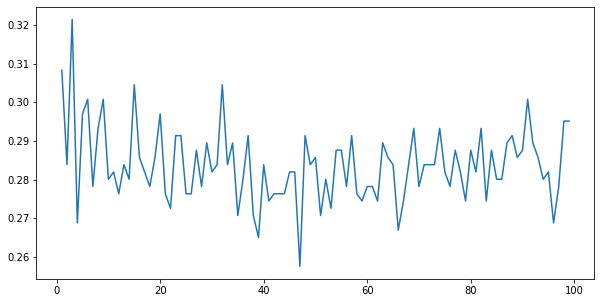

In [22]:
err = []
for i in range(1,100):
    rfc = RandomForestClassifier(n_estimators=i)
    rfc.fit(X_train, y_train)
    rfc_predictions = rfc.predict(X_test)
    err.append(np.mean(rfc_predictions!=y_test))
    #err.append(f1_score(y_test, rfc_predictions, average='weighted'))

plt.figure(figsize=(10,5))
plt.plot(range(1,100),err)  

rfc = RandomForestClassifier(n_estimators=11)
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)
#err.append(np.mean(rfc_predictions!=y_test))    
    
print(confusion_matrix(rfc_predictions,y_test))
print('\n')
print(classification_report(rfc_predictions,y_test))

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(1,100),err)    

In [23]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[419   0]
 [113   0]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       419
           1       0.00      0.00      0.00       113

    accuracy                           0.79       532
   macro avg       0.39      0.50      0.44       532
weighted avg       0.62      0.79      0.69       532



C:\Users\ayaei\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ayaei\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:

# C controls the cost of misclassification of training
# large C gives low bias and high variance (overfitting) because you penalize the cost of misclassification
# low C underfits (high bias, low variance)

# gamma: radial basis function, gamma is a free param in it, small gamma gives a gaussian with a higher vairnace
# large gamma -> high variance low bias
# default gamma = 1/n_features
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[.001, .01, 0.1], 'gamma':[10,1,.1]}
grid = GridSearchCV(SVC(), param_grid, verbose=3)
grid.fit(X_train, y_train)
grid.best_params_
grid.best_estimator_
grid_predictions = grid.predict(X_test)


In [ ]:
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))
grid.best_params_

In [24]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=500)
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

C:\Users\ayaei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


NameError: name 'grid_predictions' is not defined

In [ ]:
logmodel

In [ ]:
#data['dst'].loc[data['biomarker_id']==pid] = check(patient_profiles[inst_ind]["patient_profiles"][pat_ind]['status'].get('disease_sub_type')
                                                   
                                                   
#check(patient_profiles[inst_ind]["patient_profiles"][pat_ind]['status'].get('disease_sub_type'))
data['dst'].loc[data['biomarker_id']==pid]
data.loc[data['biomarker_id']==pid]
data.head(20)


def check(val):
    if val:
        return val
    else:
        return np.nan
    
    
print(check(patient_profiles[inst_ind]["patient_profiles"][0]['demographics'].get('race')))
print(check(patient_profiles[inst_ind]["patient_profiles"][1]['demographics'].get('race')))


print(check(patient_profiles[1]["patient_profiles"][2]['demographics'].get('race')))

print(check(patient_profiles[6]["patient_profiles"][0]['demographics'].get('race')))



#data['dst'].loc[data['biomarker_id']==pid] = patient_profiles[inst_ind]["patient_profiles"][pat_ind]['status']['disease_sub_type']
        
#data.head()    
#data.isin(['89c43bb4'])    
#data[data['biomarker_id']=='89c43bb4']['institution'] = patient_profiles[0]["institution"]
#data['institution'].loc[data['biomarker_id']=='89c43bb4'] = patient_profiles[0]["institution"]

#inst_ind = 1
#pat_ind = 2
#patient_profiles[inst_ind]["patient_profiles"][pat_ind]['patient_id']
#patient_profiles[inst_ind]["patient_profiles"][pat_ind]['demographics']['gender']


In [ ]:
data.head()

In [ ]:
#len(patient_profiles[0]["patient_profiles"])
#pid = patient_profiles[0]["patient_profiles"][0]['patient_id']
#pid
#data.loc['10e32947f']

patient_profiles[0]["institution"]

In [ ]:
print(json.dumps(patient_profiles, indent=4))
#patient_profiles[2]["institution"]
